
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Climate emulator output generation

inputs required: 
  * historical wave and water level conditions
  * emulator output - synthetic wave and water level conditions
  
in this notebook:
  * plot the historical and synthetic values of the analyzed variables
  * generation of hourly values of the synthetic time series
  
  


### TODO
- find a way to store 'max_storms' mask at complete simulation hourly (extreme computational cost)

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates

from teslakit.plotting.climate_emulator import Plot_Complete



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

n_sims_DWTs = 10



## Historical Waves and Climate Data

In [3]:
# Generate historical complete hourly data and 
HIST_COMPLETE_h = db.Generate_HIST_Complete()

# set AT reference level (mean at 0)
HIST_COMPLETE_h['AT'] = HIST_COMPLETE_h['AT'] - np.nanmean(HIST_COMPLETE_h['AT'])

# calculate AWL, TWL and level
HIST_COMPLETE_h['AWL'] = AWL(HIST_COMPLETE_h.Hs, HIST_COMPLETE_h.Tp)
HIST_COMPLETE_h['TWL'] = HIST_COMPLETE_h['AWL'] + HIST_COMPLETE_h['AT'] + HIST_COMPLETE_h['MMSL']
HIST_COMPLETE_h['level'] = HIST_COMPLETE_h['AT'] + HIST_COMPLETE_h['MMSL']

# add mask for max_storms times
HIST_COMPLETE_h['max_storms'] = HIST_COMPLETE_h.time.isin(CE.WVS_MS.time)

# store hourly historical data
db.Save_HIST_Complete_hourly(HIST_COMPLETE_h)

print(HIST_COMPLETE_h)


<xarray.Dataset>
Dimensions:      (time: 1331113)
Coordinates:
  * time         (time) datetime64[ns] 1880-06-01 ... 2018-04-08
Data variables:
    observed     (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ntr          (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    sigma        (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    AT           (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    AWT          (time) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... nan nan nan nan nan
    DWT          (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Hs           (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Tp           (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Dir          (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    sea_Hs       (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    sea_Tp       (time) float64 nan nan nan nan nan nan 

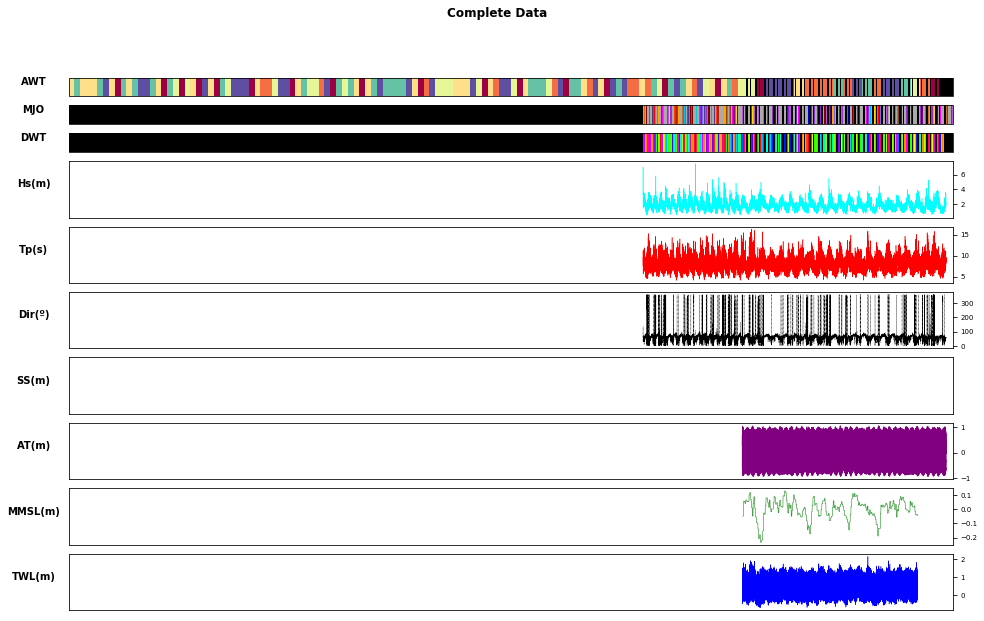

In [4]:
# Plot Historical 

Plot_Complete(HIST_COMPLETE_h);



## Simulated Waves and Climate Data

In [5]:
# --------------------------------------
# Climate Emulator extremes model output

def waves_hourly(CE, n_sims_DWTs, n_sim_ce=0):
    '''
    Generate hourly simulation output. 
    
    - join DWTs-WVs Climate emulator simulations for all n_sims_DWTs
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - calculates AWL
    
    return xarray.Dataset with dims: n_sim (DWTs-WVs), time (hourly)
    '''

    # iterate simulations
    ls_hy = []
    for n in range(n_sims_DWTs):
        print('\n - Sim: {0} -'.format(int(n)+1))

        _, TCS_sim, WVS_upd = CE.LoadSim(n_sim = n)    
        
        # select one Climate Emulator sim. for each DWT sim.
        WVS_upd = WVS_upd.isel(n_sim = n_sim_ce)  
        TCS_sim = TCS_sim.isel(n_sim = n_sim_ce)
        
        # Aggregate waves families
        wvs_agr = Aggregate_WavesFamilies(WVS_upd)

        # Calculate Intradaily hourly hydrographs for simulated storms
        hy = Intradaily_Hydrograph(wvs_agr, TCS_sim)
        print('intradaily hydrographs generated.')

        # TODO: too computational demanding...
        # add mask for max_storms times
        #hy['max_storms'] = hy.time.isin(np.array(WVS_upd.time, dtype='datetime64[ns]'))
        #print('max_storm times added.')

        ls_hy.append(hy)
        
    # combine hourly simulations
    hy = xr.concat(ls_hy, 'n_sim')

    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)

    
    return hy


# Generate hourly waves using intradaily hydrographs
WVS_sim_h = waves_hourly(CE, n_sims_DWTs)  

# store hourly simulated waves data
db.Save_SIM_Waves_hourly(WVS_sim_h)

print(WVS_sim_h)



 - Sim: 1 -
intradaily hydrographs generated.

 - Sim: 2 -
intradaily hydrographs generated.

 - Sim: 3 -
intradaily hydrographs generated.

 - Sim: 4 -
intradaily hydrographs generated.

 - Sim: 5 -
intradaily hydrographs generated.

 - Sim: 6 -
intradaily hydrographs generated.

 - Sim: 7 -
intradaily hydrographs generated.

 - Sim: 8 -
intradaily hydrographs generated.

 - Sim: 9 -
intradaily hydrographs generated.

 - Sim: 10 -
intradaily hydrographs generated.
<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765833)
Coordinates:
  * time     (time) object 2000-01-01 2000-01-01T01:00:00 ... 3000-01-01
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 1.164 1.164 1.164 1.164 ... 1.499 1.497 1.495
    Tp       (n_sim, time) float32 10.3296385 10.3296385 ... 7.051591 9.525047
    Dir      (n_sim, time) float32 59.32871 59.32871 ... 54.99999 353.16177
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_s


## Complete Simulation: load covariates and merge with hourly waves

In [6]:
# --------------------------------------
# Covariates: AWTs, DWTs, MJO, MMSL, AT

# Generate hourly covariates data
CVS_sim_h = db.Generate_SIM_Covariates(total_sims=n_sims_DWTs)

# set AT reference level (mean at 0)
for s in CVS_sim_h.n_sim:
    CVS_sim_h.sel(n_sim=s)['AT'].values[:] = CVS_sim_h.sel(n_sim=s)['AT'] - np.nanmean(CVS_sim_h.sel(n_sim=s)['AT'])

# store hourly covariates
db.Save_SIM_Covariates_hourly(CVS_sim_h)


In [7]:
# --------------------------------------
# Complete simulation output 

d1, d2 = xds_limit_dates([WVS_sim_h, CVS_sim_h])
WVS_sim_h = WVS_sim_h.sel(time = slice(d1, d2))
CVS_sim_h = CVS_sim_h.sel(time = slice(d1, d2))

# merge all data
SIM_COMPLETE_h = xr.merge([WVS_sim_h, CVS_sim_h])

# calculate TWL and level
SIM_COMPLETE_h['TWL'] = SIM_COMPLETE_h['AWL'] + SIM_COMPLETE_h['SS'] + SIM_COMPLETE_h['AT'] + SIM_COMPLETE_h['MMSL']
SIM_COMPLETE_h['level'] = SIM_COMPLETE_h['SS'] + SIM_COMPLETE_h['AT'] + SIM_COMPLETE_h['MMSL']

# store hourly complete data
db.Save_SIM_Complete_hourly(SIM_COMPLETE_h)

print(SIM_COMPLETE_h)


<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765832)
Coordinates:
  * time     (time) object 2000-01-01 ... 2999-12-31T23:00:00
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 1.164 1.164 1.164 1.164 ... 1.5 1.499 1.497
    Tp       (n_sim, time) float32 10.3296385 10.3296385 ... 7.051591 7.051591
    Dir      (n_sim, time) float32 59.32871 59.32871 ... 54.99999 54.99999
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.4788 0.4788 0.4788 ... 0.3711 0.3709 0.3707
    AWT      (n_sim, time) int64 5 5 5 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3 3 3 3
    MJO      (n_sim, time) int64 23 23 23 23 23 23 23 ... 25 25 25 25 25 25 25
    DWT      (n_sim, time) int64 27 27 27 27 27 27 27 ... 16 16 16 16 16 16 16
    MMSL     (n_sim, time) float32 -0.022942495 -0.022942495 ... -0.101341076
    AT       (time) float32 0.29987958 0.35379007 ... -0.3778169 -0.5707504
    TWL      (n_sim, time) f

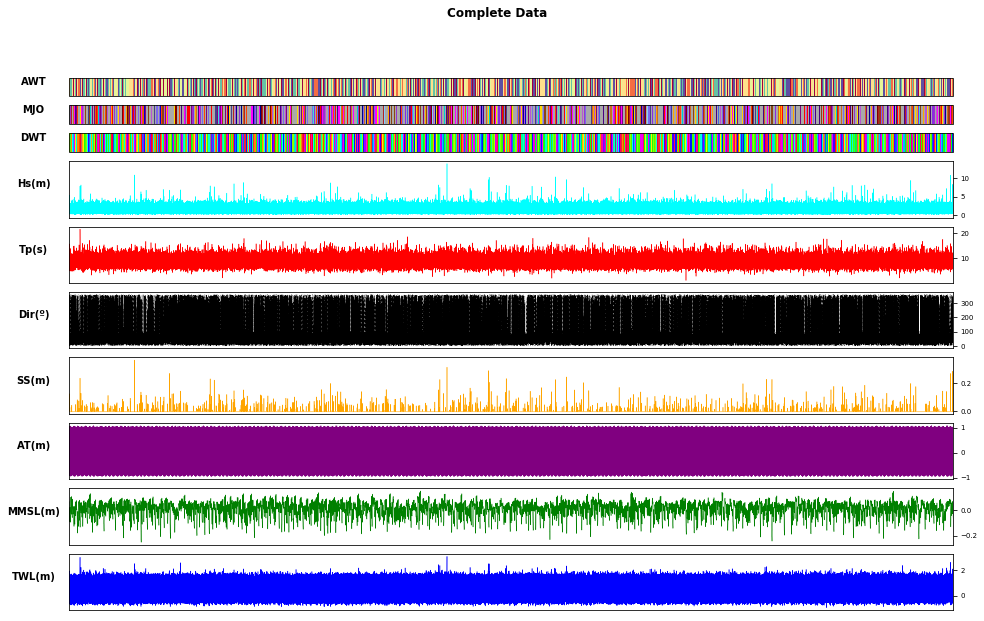

In [8]:
# Plot one Simulation 

Plot_Complete(SIM_COMPLETE_h.sel(n_sim=0));
